In [9]:
import numpy as np
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

matplotlib.rc('figure', max_open_warning = 0)

indian_map = mpimg.imread("/content/map-of-india-political.png")
def show_cities(path, w=12, h=8):
    """Plot a TSP path overlaid on a map of the indian States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]
    plt.imshow(indian_map)
    for x0, y0 in path:
        plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])


def show_path(path, starting_city=None, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]

    starting_city = starting_city or path[0]
    x, y = list(zip(*path))
    # (x0, y0) = starting_city
    plt.imshow(indian_map)
    # plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])


def polyfit_plot(x,y,deg, **kwargs):
    coefficients = np.polyfit(x,y,deg,**kwargs)
    poly  = np.poly1d(coefficients)
    new_x = np.linspace(x[0], x[-1])
    new_y = poly(new_x)
    plt.plot(x, y, "o", new_x, new_y)
    plt.xlim([x[0]-1, x[-1] + 1 ])

    terms = []
    for p, c in enumerate(reversed(coefficients)):
        term = str(round(c,1))
        if p == 1: term += 'x'
        if p >= 2: term += 'x^'+str(p)
        terms.append(term)
    plt.title(" + ".join(reversed(terms)))

[('qxwfyuuyfr', (764.6, 205.3)), ('vgndqdxatq', (468.2, 78.6)), ('gfydqvarad', (462.0, 56.6)), ('xeteyzprgg', (447.2, 98.2)), ('ckvhhhqpri', (95.4, 191.1))]


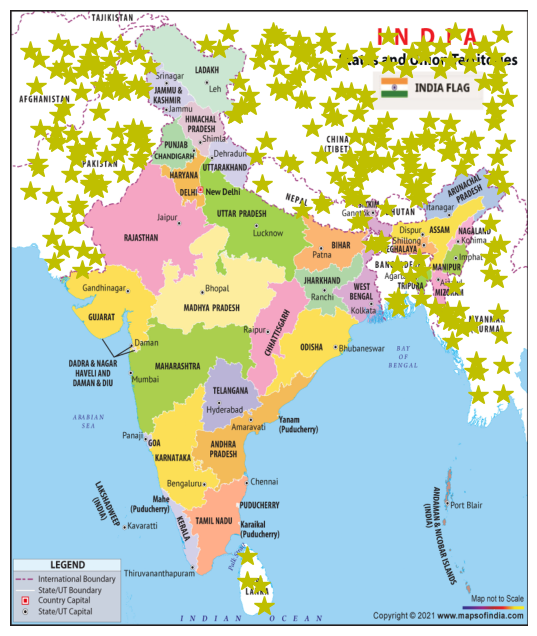

In [10]:
import string
def create_cities(size, max_x=1000, max_y=1000, image=None, color=1, border=30):
    if (image is not None):
        max_x = image.shape[0] - 1 - border*2
        max_y = image.shape[1] - 1 - border*2
    cities = {}
    while len(cities) <= size:
        name = ''.join(random.choices(string.ascii_lowercase, k=10))
        x = round( border + random.random() * max_x,  1)
        y = round( border + random.random() * max_y,  1)
        if (image is not None) and not all( image[int(x)][int(y)] == color ): continue
        cities[(int(x),int(y))] = ( name, (y,x) )
    return list(cities.values())

cities = create_cities(256, image=indian_map)
print(cities[:5])
show_cities(cities)

In [11]:
import time
from itertools import chain
from typing import Any, Callable, List, Tuple, Union

import numpy as np
import random



class AntColonySolver:
    def __init__(self,
                 cost_fn: Callable[[Any,Any], Union[float,int]] = None,

                 time=0,                  # run for a fixed amount of time
                 min_time=0,              # minimum runtime
                 timeout=0,               # maximum time in seconds to run for
                 stop_factor=2,           # how many times to redouble effort after new new best path
                 min_round_trips=4,       # minimum number of round trips before stopping
                 max_round_trips=0,       # maximum number of round trips before stopping
                 min_ants=0,              # Total number of ants to use
                 max_ants=0,              # Total number of ants to use

                 ant_count=1024,          # this is close to the optimal number for numpy performance
                 ant_speed=1,             # how many steps do ants travel per epoch

                 distance_power=1,        # power to which distance affects pheromones
                 pheromone_power=1.25,    # power to which differences in pheromones are noticed
                 decay_power=0,           # how fast do pheromones decay
                 reward_power=0,          # relative pheromone reward based on best_path_length/path_length
                 best_path_smell=2,       # queen multiplier for pheromones upon finding a new best path
                 start_smell=0,           # amount of starting pheromones [0 defaults to `10**self.distance_power`]
                 backtracking=False,      # Allow ants to revisit previous city - NEW FEATURE

                 verbose=False,

    ):
        self.cost_fn         = cost_fn or self.distance
        self.time            = int(time)
        self.min_time        = int(min_time)
        self.timeout         = int(timeout)
        self.stop_factor     = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants        = int(min_ants)
        self.max_ants        = int(max_ants)

        self.ant_count       = int(ant_count)
        self.ant_speed       = int(ant_speed)

        self.distance_power  = float(distance_power)
        self.pheromone_power = float(pheromone_power)
        self.decay_power     = float(decay_power)
        self.reward_power    = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell     = float(start_smell or 10**self.distance_power)
        self.backtracking    = backtracking

        self.verbose         = int(verbose)
        self._initalized     = False

        if self.min_round_trips and self.max_round_trips: self.min_round_trips = min(self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:               self.min_ants        = min(self.min_ants, self.max_ants)


    @staticmethod
    def distance(xy1, xy2) -> float:
        if isinstance(xy1[0], str): xy1 = xy1[1]; xy2 = xy2[1];               # if xy1 == ("Name", (x,y))
        return math.sqrt( (xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2 )

    @staticmethod
    def path_distance(path) -> int:
        if isinstance(path, dict):      path = list(path.values())            # if path == {"Name": (x,y)}
        if isinstance(path[0][0], str): path = [ item[1] for item in path ]   # if path == ("Name", (x,y))
        return int(sum(
            [ distance(path[i],  path[i+1]) for i in range(len(path)-1) ]
          + [ distance(path[-1], path[0]) ]                                   # include cost of return journey
        ))


    def solve_initialize(
            self,
            problem_path: List[Any],
    ) -> None:
        ### Cache of distances between nodes
        self.distances = {
            source: {
                dest: self.cost_fn(source, dest)
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Cache of distance costs between nodes - division in a tight loop is expensive
        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source][dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }

        ### This stores the pheromone trail that slowly builds up
        self.pheromones = {
            source: {
                # Encourage the ants to start exploring in all directions and furthest nodes
                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Heuristic Exports
        self.ants_used   = 0
        self.epochs_used = 0
        self.round_trips = 0

        self._initalized = True


    def solve(self,
              problem_path: List[Any],
              restart=False,
    ) -> List[Tuple[int,int]]:

        if restart or not self._initalized:
            self.solve_initialize(problem_path)

        ### Reset Heuristics
        self.ants_used   = 0
        self.epochs_used = 0
        self.round_trips = 0

        ### Sanitise input parameters
        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = np.median(list(chain(*[ d.values() for d in self.distances.values() ]))) // 5
        self.ant_speed = int(max(1,self.ant_speed))

        ### Here come the ants!
        ants = {
            "distance":    np.zeros((self.ant_count,)).astype('int32'),
            "path":        [ [ problem_path[0] ]   for n in range(self.ant_count) ],
            "remaining":   [ set(problem_path[1:]) for n in range(self.ant_count) ],
            "path_cost":   np.zeros((self.ant_count,)).astype('int32'),
            "round_trips": np.zeros((self.ant_count,)).astype('int32'),
        }

        best_path       = None
        best_path_cost  = np.inf
        best_epochs     = []
        epoch           = 0
        time_start      = time.perf_counter()
        while True:
            epoch += 1

            ### Vectorized walking of ants
            # Small optimization here, testing against `> self.ant_speed` rather than `> 0`
            #       avoids computing ants_arriving in the main part of this tight loop
            ants_travelling = (ants['distance'] > self.ant_speed)
            ants['distance'][ ants_travelling ] -= self.ant_speed
            if all(ants_travelling):
                continue  # skip termination checks until the next ant arrives

            ### Vectorized checking of ants arriving
            ants_arriving       = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]
            for i in ants_arriving_index:

                ### ant has arrived at next_node
                this_node = ants['path'][i][-1]
                next_node = self.next_node(ants, i)
                ants['distance'][i]  = self.distances[ this_node ][ next_node ]
                ants['remaining'][i] = ants['remaining'][i] - {this_node}
                ants['path_cost'][i] = ants['path_cost'][i] + ants['distance'][i]
                ants['path'][i].append( next_node )

                ### ant has returned home to the colony
                if not ants['remaining'][i] and ants['path'][i][0] == ants['path'][i][-1]:
                    self.ants_used  += 1
                    self.round_trips = max(self.round_trips, ants["round_trips"][i] + 1)

                    ### We have found a new best path - inform the Queen
                    was_best_path = False
                    if ants['path_cost'][i] < best_path_cost:
                        was_best_path  = True
                        best_path_cost = ants['path_cost'][i]
                        best_path      = ants['path'][i]
                        best_epochs   += [ epoch ]
                        if self.verbose:
                            print({
                                "path_cost":   int(ants['path_cost'][i]),
                                "ants_used":   self.ants_used,
                                "epoch":       epoch,
                                "round_trips": ants['round_trips'][i] + 1,
                                "clock":       int(time.perf_counter() - time_start),
                            })

                    ### leave pheromone trail
                    # doing this only after ants arrive home improves initial exploration
                    #  * self.round_trips has the effect of decaying old pheromone trails
                    # ** self.reward_power = -3 has the effect of encouraging ants to explore longer routes
                    #                           in combination with doubling pheromone for best_path
                    reward = 1
                    if self.reward_power: reward *= ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
                    if self.decay_power:  reward *= (self.round_trips ** self.decay_power)
                    for path_index in range( len(ants['path'][i]) - 1 ):
                        this_node = ants['path'][i][path_index]
                        next_node = ants['path'][i][path_index+1]
                        self.pheromones[this_node][next_node] += reward
                        self.pheromones[next_node][this_node] += reward
                        if was_best_path:
                            # Queen orders to double the number of ants following this new best path
                            self.pheromones[this_node][next_node] *= self.best_path_smell
                            self.pheromones[next_node][this_node] *= self.best_path_smell


                    ### reset ant
                    ants["distance"][i]     = 0
                    ants["path"][i]         = [ problem_path[0] ]
                    ants["remaining"][i]    = set(problem_path[1:])
                    ants["path_cost"][i]    = 0
                    ants["round_trips"][i] += 1


            ### Do we terminate?

            # Always wait for at least 1 solutions (note: 2+ solutions are not guaranteed)
            if not len(best_epochs): continue

            # Timer takes priority over other constraints
            if self.time or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time:
                    if clock > self.time: break
                    else:                 continue
                if self.min_time and clock < self.min_time: continue
                if self.timeout  and clock > self.timeout:  break

            # First epoch only has start smell - question: how many epochs are required for a reasonable result?
            if self.min_round_trips and self.round_trips <  self.min_round_trips: continue
            if self.max_round_trips and self.round_trips >= self.max_round_trips: break

            # This factor is most closely tied to computational power
            if self.min_ants and self.ants_used <  self.min_ants: continue
            if self.max_ants and self.ants_used >= self.max_ants: break

            # Lets keep redoubling our efforts until we can't find anything more
            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor): break

            # Nothing else is stopping us: Queen orders the ants to continue!
            if True: continue



        ### We have (hopefully) found a near-optimal path, report back to the Queen
        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return best_path


    def next_node(self, ants, index):
        this_node   = ants['path'][index][-1]

        weights     = []
        weights_sum = 0
        if not ants['remaining'][index]: return ants['path'][index][0]  # return home

        ants_remaining_index = ants['remaining'][index]
        if self.backtracking: ants_remaining_index = ants_remaining_index | {this_node}
        for next_node in ants_remaining_index:
            if next_node == this_node: continue
            reward = (
                    self.pheromones[this_node][next_node] ** self.pheromone_power
                    * self.distance_cost[this_node][next_node]  # Prefer shorter paths
            )
            weights.append( (reward, next_node) )
            weights_sum   += reward

        # Pick a random path in proportion to the weight of the pheromone
        rand = random.random() * weights_sum
        for (weight, next_node) in weights:
            if rand > weight: rand -= weight
            else:             break
        return next_node


def AntColonyRunner(cities, verbose=False, plot=False, label={}, algorithm=AntColonySolver, **kwargs):
    solver     = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result     = solver.solve(cities)
    stop_time  = time.perf_counter()
    if label: kwargs = { **label, **kwargs }

    for key in ['verbose', 'plot', 'animate', 'label', 'min_time', 'max_time']:
        if key in kwargs: del kwargs[key]
    print("N={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | ants: {:5d} | trips: {:2d} | "
          .format(len(cities), path_distance(cities), path_distance(result), (stop_time - start_time), solver.ants_used, solver.round_trips)
          + " ".join([ f"{k}={v}" for k,v in kwargs.items() ])
    )
    if plot:
        show_path(result)
    return result


distance      = AntColonySolver.distance
path_distance = AntColonySolver.path_distance


In [12]:

from typing import Dict
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from itertools import chain, product, combinations
class KmeansAntColonySolver(AntColonySolver):
    def __init__(self,
                 animate: Callable=None,

                 cluster_factor=1.05,           # Multiple for subdividng the problem
                 random_factor=1,               # Greate random subgroups - this doesn't work
                 distance_power_multiple=1.5,   # Increase distance_power before final solve
                 intercity_merge=0,             # For each pair of clusters, find a loop between the N nearest neighbours of each
                 intercity_loop=0,              # Construct loops between clusters using N nearest neighbours for each cluster
                 intercity_random=0,            # Construct loops between random members of each cluster

                 start_smell=2,
                 start_smell_normalization=0.5,
                 min_round_trips=2,
                 max_round_trips=0,             # performance shortcut
                 best_path_smell=1.25,          # 2*1 + 1.25*0.5 work best
                 best_path_smell_multiple=0.5,  # Increase best_path_smell before final solve
                 min_clusters=2,
                 min_cluster_size=3,

                 **kwargs
    ):
        self.min_clusters         = min_clusters
        self.min_cluster_size     = min_cluster_size


        self.animate              = animate
        self.intercity_merge      = intercity_merge
        self.intercity_loop       = intercity_loop
        self.intercity_random     = intercity_random
        self.cluster_factor       = cluster_factor
        self.random_factor        = random_factor
        self.distance_power_multiple   = distance_power_multiple
        self.best_path_smell_multiple  = best_path_smell_multiple
        self.start_smell_normalization = start_smell_normalization


        self.kwargs = {
            "start_smell":     start_smell,
            "min_round_trips": min_round_trips,
            "max_round_trips": max_round_trips,
            "best_path_smell": best_path_smell,
            **kwargs
        }
        super().__init__(**self.kwargs)


    def get_numeric_path(self, problem_path: List[Any]) -> List[Tuple[int,int]]:
        # KMeans requires: List[Tuple[int,int]]
        numeric_path = list(problem_path)
        try:
            if isinstance(numeric_path, dict):      numeric_path = list(numeric_path.values())            # if path == {"Name": (x,y)}
            if isinstance(numeric_path[0][0], str): numeric_path = [ item[1] for item in numeric_path ]   # if path == ("Name", (x,y))
        except: pass
        return numeric_path


    def group_by_random(self, problem_path: List[Any], n_clusters) -> Dict[int, List[Any]]:
            clusters = [
                random.sample(problem_path, math.ceil(len(problem_path) / n_clusters) )
                for n in range(int(n_clusters))
            ]
            return clusters


    def group_by_kmeans(self, problem_path: List[Any], n_clusters) -> Dict[int, List[Any]]:
            if n_clusters == 1: return [ problem_path ]

            # Group the cities into KMeans cluster groups of increasing size
            numeric_path = self.get_numeric_path(problem_path)
            cluster_ids  = KMeans(n_clusters=n_clusters).fit_predict(numeric_path)
            clusters = [
                list({ problem_path[n] for n in range(len(problem_path)) if cluster_ids[n] == cluster_id })
                for cluster_id in np.unique(cluster_ids)
            ]
            return clusters


    def centroid(self, problem_path: List[Tuple[Any]]) -> Tuple[int,int]:
        numeric_path = self.get_numeric_path(problem_path)
        return tuple(np.median(numeric_path, axis=0))

    # Returns the two nearest neighbours to the centeroid for each cluster
    def nearest_neighbors(self, clusters: List[List[Any]], n_neighbors=2) -> List[List[Any]]:
        center_point = self.centroid(chain(*clusters))
        clusters_of_nearest = []
        for cluster in clusters:
            numeric_path   = self.get_numeric_path(cluster)
            nn             = NearestNeighbors(n_neighbors).fit(numeric_path)
            dist, indicies = nn.kneighbors([center_point])  # inputs and outputs are both arrays
            clusters_of_nearest.append([ cluster[i] for i in indicies[0] ])
        return clusters_of_nearest


    def normalize_pheromones(self, norm: float=None):
        norm   = norm or self.start_smell
        mean   = np.mean(list(chain(*[ d.values() for d in self.pheromones.values() ])))
        weight = norm / mean
        for source in self.pheromones.keys():
            for dest in self.pheromones.keys():
                self.pheromones[source][dest] *= norm
                self.pheromones[source][dest] += norm * self.start_smell_normalization


    def solve(self,
              problem_path: List[Any],
              restart=True,
    ) -> List[Tuple[int,int]]:
        # Initialize the Solver - preserve the pheromone trail between runs
        self.solve_initialize(problem_path)

        # Break the Travelling Salesman problem down into local clusters of nodes, as detected by KMeans
        # Iteratively decrease the number of clusters, until we are back at the starting problem

        n_clusters = int( len(problem_path) / ( self.cluster_factor * self.random_factor ) )
        random_clusters = self.group_by_random(problem_path, self.random_factor)

        results_plot = {}
        while n_clusters > self.min_clusters:

            results_plot[n_clusters] = []
            results_plot[f"{n_clusters}_loop"]  = []
            results_plot[f"{n_clusters}_merge"] = []

            for random_cluster in random_clusters:
                kmeans_clusters = self.group_by_kmeans(random_cluster, int(n_clusters))
                kmeans_clusters = [ cluster for cluster in kmeans_clusters if len(cluster) >= self.min_cluster_size ]

                # Break the map down into kmeans subclusters and create a heuristic pheromone trail
                for kmeans_cluster in kmeans_clusters:
                    if len(kmeans_cluster) < self.min_cluster_size: continue
                    results = self.solve_subproblem(kmeans_cluster, restart=False)
                    results_plot[n_clusters] += [ results ]

                if len(kmeans_clusters) <= 1: continue  # Can't do intercity with a single cluster

                # Construct a loop between clusters, using the N closest members to the centeroid from each cluster
                if self.intercity_loop:
                    intercity = self.nearest_neighbors(kmeans_clusters, self.intercity_loop)
                    intercity = list(chain(*intercity))
                    results   = self.solve_subproblem(intercity, restart=False)
                    results_plot[f"{n_clusters}_loop"] += [ results ]

                if self.intercity_random:
                    intercity = [ random.sample(cluster, max(self.intercity_random, len(cluster)-1)) for cluster in kmeans_clusters ]
                    intercity = list(chain(*intercity))
                    results   = self.solve_subproblem(intercity, restart=False)
                    results_plot[f"{n_clusters}_loop"] += [ results ]

                # For each pair of clusters, find the optimal path to join them using their N nearest neighbours
                if self.intercity_merge:
                    for clusters in combinations(kmeans_clusters, 2):
                        intercity = self.nearest_neighbors(clusters, self.intercity_merge)
                        intercity = list(chain(*intercity))
                        results   = self.solve_subproblem(intercity, restart=False)
                        results_plot[f"{n_clusters}_merge"] += [ results ]


            # self.normalize_pheromones()
            n_clusters = int( (n_clusters) // ( self.cluster_factor * self.random_factor ) )

        # Display the growth of clusters
        if callable(self.animate):
            self.animate_results(results_plot, problem_path)

        # Now solve the original problem
        for key, value in self.kwargs.items():
            if hasattr(self, key): setattr(self, key, value)

        self.normalize_pheromones()
        self.distance_power  *= self.distance_power_multiple
        self.best_path_smell *= self.best_path_smell_multiple
        self.round_trips = 0
        self.ant_count   = 4 * len(problem_path)
        #self.min_ants    = self.ants_used + len(problem_path) ** 2 / 2
        self.max_ants    = self.ants_used + len(problem_path) ** 2 * 2
        result = super().solve(problem_path)

        if callable(self.animate):
            plt.figure()
            self.animate(result)

        return result


    def solve_subproblem(self,
              problem_path: List[Any],
              restart=True,
    ) -> List[Tuple[int,int]]:
        verbose = self.verbose
        self.round_trips = 0
        self.ant_count   = 4 * len(problem_path)
        #self.min_ants    = 0 # len(problem_path) ** 2 / 2
        #self.max_ants    = 0 # self.ants_used + len(problem_path) ** 2

        time_start    = time.perf_counter()
        self.verbose  = False
        result        = super().solve(problem_path, restart=False)
        # self.normalize_pheromones_path(problem_path, 10000)
        self.verbose  = verbose
        if self.verbose:
            print(
                f'solve({len(problem_path)})', path_distance(problem_path), '->', path_distance(result),
                { "ant_count": self.ant_count, "ants_used": self.ants_used, "round_trips": self.round_trips,  "time": round(time.perf_counter() - time_start, 1) }
             )
        return result


    def animate_results(self, results_plot: Dict[int, List[Any]], problem_path=[]) -> None:
        results_plot = { k:v for k,v in results_plot.items() if len(v) }  # remove empty results
        if not len(results_plot):      return
        if not callable(self.animate): return

        grid_cols = max(4, math.ceil(np.sqrt(len(results_plot))))
        grid_cols = min(grid_cols,len(results_plot))
        grid_rows = math.ceil(len(results_plot)/grid_cols)
        grid_size = ( grid_rows, grid_cols )
        figure, axes = plt.subplots(*grid_size, figsize=(grid_size[0]*10, grid_size[1]*10))
        plt.tight_layout(pad=5)
        try:
            for ax in chain(*axes): ax.axis('off')
        except: pass

        for index, N in enumerate(results_plot.keys()):
            plt.subplot(*grid_size, index+1)
            unique_lengths = list(np.unique(list(map(len,results_plot[N]))))
            plt.title(f'{len(problem_path)}/{N} = {len(results_plot[N])} clusters')
            for results in results_plot[N]:
                self.animate(results)
        #plt.close(figure)



def KmeansAntColonyRunner(cities, animate=False, **kwargs):
    if animate is True: animate=show_path
    kwargs = { "animate": animate, "algorithm": KmeansAntColonySolver, **kwargs }
    return AntColonyRunner(cities, **kwargs)

In [13]:
from typing import Dict
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from itertools import chain, product, combinations
class KmeansAntColonySolver(AntColonySolver):
    def __init__(self,
                 animate: Callable=None,

                 cluster_factor=1.05,           # Multiple for subdividng the problem
                 random_factor=1,               # Greate random subgroups - this doesn't work
                 distance_power_multiple=1.5,   # Increase distance_power before final solve
                 intercity_merge=0,             # For each pair of clusters, find a loop between the N nearest neighbours of each
                 intercity_loop=0,              # Construct loops between clusters using N nearest neighbours for each cluster
                 intercity_random=0,            # Construct loops between random members of each cluster

                 start_smell=2,
                 start_smell_normalization=0.5,
                 min_round_trips=2,
                 max_round_trips=0,             # performance shortcut
                 best_path_smell=1.25,          # 2*1 + 1.25*0.5 work best
                 best_path_smell_multiple=0.5,  # Increase best_path_smell before final solve
                 min_clusters=2,
                 min_cluster_size=3,

                 **kwargs
    ):
        self.min_clusters         = min_clusters
        self.min_cluster_size     = min_cluster_size


        self.animate              = animate
        self.intercity_merge      = intercity_merge
        self.intercity_loop       = intercity_loop
        self.intercity_random     = intercity_random
        self.cluster_factor       = cluster_factor
        self.random_factor        = random_factor
        self.distance_power_multiple   = distance_power_multiple
        self.best_path_smell_multiple  = best_path_smell_multiple
        self.start_smell_normalization = start_smell_normalization


        self.kwargs = {
            "start_smell":     start_smell,
            "min_round_trips": min_round_trips,
            "max_round_trips": max_round_trips,
            "best_path_smell": best_path_smell,
            **kwargs
        }
        super().__init__(**self.kwargs)


    def get_numeric_path(self, problem_path: List[Any]) -> List[Tuple[int,int]]:
        # KMeans requires: List[Tuple[int,int]]
        numeric_path = list(problem_path)
        try:
            if isinstance(numeric_path, dict):      numeric_path = list(numeric_path.values())            # if path == {"Name": (x,y)}
            if isinstance(numeric_path[0][0], str): numeric_path = [ item[1] for item in numeric_path ]   # if path == ("Name", (x,y))
        except: pass
        return numeric_path


    def group_by_random(self, problem_path: List[Any], n_clusters) -> Dict[int, List[Any]]:
            clusters = [
                random.sample(problem_path, math.ceil(len(problem_path) / n_clusters) )
                for n in range(int(n_clusters))
            ]
            return clusters


    def group_by_kmeans(self, problem_path: List[Any], n_clusters) -> Dict[int, List[Any]]:
            if n_clusters == 1: return [ problem_path ]

            # Group the cities into KMeans cluster groups of increasing size
            numeric_path = self.get_numeric_path(problem_path)
            cluster_ids  = KMeans(n_clusters=n_clusters).fit_predict(numeric_path)
            clusters = [
                list({ problem_path[n] for n in range(len(problem_path)) if cluster_ids[n] == cluster_id })
                for cluster_id in np.unique(cluster_ids)
            ]
            return clusters


    def centroid(self, problem_path: List[Tuple[Any]]) -> Tuple[int,int]:
        numeric_path = self.get_numeric_path(problem_path)
        return tuple(np.median(numeric_path, axis=0))

    # Returns the two nearest neighbours to the centeroid for each cluster
    def nearest_neighbors(self, clusters: List[List[Any]], n_neighbors=2) -> List[List[Any]]:
        center_point = self.centroid(chain(*clusters))
        clusters_of_nearest = []
        for cluster in clusters:
            numeric_path   = self.get_numeric_path(cluster)
            nn             = NearestNeighbors(n_neighbors).fit(numeric_path)
            dist, indicies = nn.kneighbors([center_point])  # inputs and outputs are both arrays
            clusters_of_nearest.append([ cluster[i] for i in indicies[0] ])
        return clusters_of_nearest


    def normalize_pheromones(self, norm: float=None):
        norm   = norm or self.start_smell
        mean   = np.mean(list(chain(*[ d.values() for d in self.pheromones.values() ])))
        weight = norm / mean
        for source in self.pheromones.keys():
            for dest in self.pheromones.keys():
                self.pheromones[source][dest] *= norm
                self.pheromones[source][dest] += norm * self.start_smell_normalization


    def solve(self,
              problem_path: List[Any],
              restart=True,
    ) -> List[Tuple[int,int]]:
        # Initialize the Solver - preserve the pheromone trail between runs
        self.solve_initialize(problem_path)

        # Break the Travelling Salesman problem down into local clusters of nodes, as detected by KMeans
        # Iteratively decrease the number of clusters, until we are back at the starting problem

        n_clusters = int( len(problem_path) / ( self.cluster_factor * self.random_factor ) )
        random_clusters = self.group_by_random(problem_path, self.random_factor)

        results_plot = {}
        while n_clusters > self.min_clusters:

            results_plot[n_clusters] = []
            results_plot[f"{n_clusters}_loop"]  = []
            results_plot[f"{n_clusters}_merge"] = []

            for random_cluster in random_clusters:
                kmeans_clusters = self.group_by_kmeans(random_cluster, int(n_clusters))
                kmeans_clusters = [ cluster for cluster in kmeans_clusters if len(cluster) >= self.min_cluster_size ]

                # Break the map down into kmeans subclusters and create a heuristic pheromone trail
                for kmeans_cluster in kmeans_clusters:
                    if len(kmeans_cluster) < self.min_cluster_size: continue
                    results = self.solve_subproblem(kmeans_cluster, restart=False)
                    results_plot[n_clusters] += [ results ]

                if len(kmeans_clusters) <= 1: continue  # Can't do intercity with a single cluster

                # Construct a loop between clusters, using the N closest members to the centeroid from each cluster
                if self.intercity_loop:
                    intercity = self.nearest_neighbors(kmeans_clusters, self.intercity_loop)
                    intercity = list(chain(*intercity))
                    results   = self.solve_subproblem(intercity, restart=False)
                    results_plot[f"{n_clusters}_loop"] += [ results ]

                if self.intercity_random:
                    intercity = [ random.sample(cluster, max(self.intercity_random, len(cluster)-1)) for cluster in kmeans_clusters ]
                    intercity = list(chain(*intercity))
                    results   = self.solve_subproblem(intercity, restart=False)
                    results_plot[f"{n_clusters}_loop"] += [ results ]

                # For each pair of clusters, find the optimal path to join them using their N nearest neighbours
                if self.intercity_merge:
                    for clusters in combinations(kmeans_clusters, 2):
                        intercity = self.nearest_neighbors(clusters, self.intercity_merge)
                        intercity = list(chain(*intercity))
                        results   = self.solve_subproblem(intercity, restart=False)
                        results_plot[f"{n_clusters}_merge"] += [ results ]


            # self.normalize_pheromones()
            n_clusters = int( (n_clusters) // ( self.cluster_factor * self.random_factor ) )

        # Display the growth of clusters
        if callable(self.animate):
            self.animate_results(results_plot, problem_path)

        # Now solve the original problem
        for key, value in self.kwargs.items():
            if hasattr(self, key): setattr(self, key, value)

        self.normalize_pheromones()
        self.distance_power  *= self.distance_power_multiple
        self.best_path_smell *= self.best_path_smell_multiple
        self.round_trips = 0
        self.ant_count   = 4 * len(problem_path)
        #self.min_ants    = self.ants_used + len(problem_path) ** 2 / 2
        self.max_ants    = self.ants_used + len(problem_path) ** 2 * 2
        result = super().solve(problem_path)

        if callable(self.animate):
            plt.figure()
            self.animate(result)

        return result


    def solve_subproblem(self,
              problem_path: List[Any],
              restart=True,
    ) -> List[Tuple[int,int]]:
        verbose = self.verbose
        self.round_trips = 0
        self.ant_count   = 4 * len(problem_path)
        #self.min_ants    = 0 # len(problem_path) ** 2 / 2
        #self.max_ants    = 0 # self.ants_used + len(problem_path) ** 2

        time_start    = time.perf_counter()
        self.verbose  = False
        result        = super().solve(problem_path, restart=False)
        # self.normalize_pheromones_path(problem_path, 10000)
        self.verbose  = verbose
        if self.verbose:
            print(
                f'solve({len(problem_path)})', path_distance(problem_path), '->', path_distance(result),
                { "ant_count": self.ant_count, "ants_used": self.ants_used, "round_trips": self.round_trips,  "time": round(time.perf_counter() - time_start, 1) }
             )
        return result


    def animate_results(self, results_plot: Dict[int, List[Any]], problem_path=[]) -> None:
        results_plot = { k:v for k,v in results_plot.items() if len(v) }  # remove empty results
        if not len(results_plot):      return
        if not callable(self.animate): return

        grid_cols = max(4, math.ceil(np.sqrt(len(results_plot))))
        grid_cols = min(grid_cols,len(results_plot))
        grid_rows = math.ceil(len(results_plot)/grid_cols)
        grid_size = ( grid_rows, grid_cols )
        figure, axes = plt.subplots(*grid_size, figsize=(grid_size[0]*10, grid_size[1]*10))
        plt.tight_layout(pad=5)
        try:
            for ax in chain(*axes): ax.axis('off')
        except: pass

        for index, N in enumerate(results_plot.keys()):
            plt.subplot(*grid_size, index+1)
            unique_lengths = list(np.unique(list(map(len,results_plot[N]))))
            plt.title(f'{len(problem_path)}/{N} = {len(results_plot[N])} clusters')
            for results in results_plot[N]:
                self.animate(results)
        #plt.close(figure)



def KmeansAntColonyRunner(cities, animate=False, **kwargs):
    if animate is True: animate=show_path
    kwargs = { "animate": animate, "algorithm": KmeansAntColonySolver, **kwargs }
    return AntColonyRunner(cities, **kwargs)

In [14]:
import warnings
warnings.filterwarnings('ignore')

solve(4) 172 -> 172 {'ant_count': 16, 'ants_used': 18, 'round_trips': 2, 'time': 0.0}
solve(4) 219 -> 171 {'ant_count': 16, 'ants_used': 26, 'round_trips': 2, 'time': 0.0}
solve(3) 170 -> 170 {'ant_count': 12, 'ants_used': 20, 'round_trips': 2, 'time': 0.0}
solve(3) 211 -> 211 {'ant_count': 12, 'ants_used': 20, 'round_trips': 2, 'time': 0.0}
solve(3) 242 -> 242 {'ant_count': 12, 'ants_used': 16, 'round_trips': 2, 'time': 0.0}
solve(5) 504 -> 380 {'ant_count': 20, 'ants_used': 38, 'round_trips': 2, 'time': 0.0}
solve(4) 367 -> 361 {'ant_count': 16, 'ants_used': 23, 'round_trips': 2, 'time': 0.0}
solve(5) 318 -> 273 {'ant_count': 20, 'ants_used': 23, 'round_trips': 2, 'time': 0.0}
solve(5) 615 -> 399 {'ant_count': 20, 'ants_used': 28, 'round_trips': 2, 'time': 0.0}
solve(6) 400 -> 355 {'ant_count': 24, 'ants_used': 25, 'round_trips': 2, 'time': 0.0}
solve(14) 2695 -> 1160 {'ant_count': 56, 'ants_used': 57, 'round_trips': 2, 'time': 0.0}
solve(11) 1503 -> 925 {'ant_count': 44, 'ants_used'

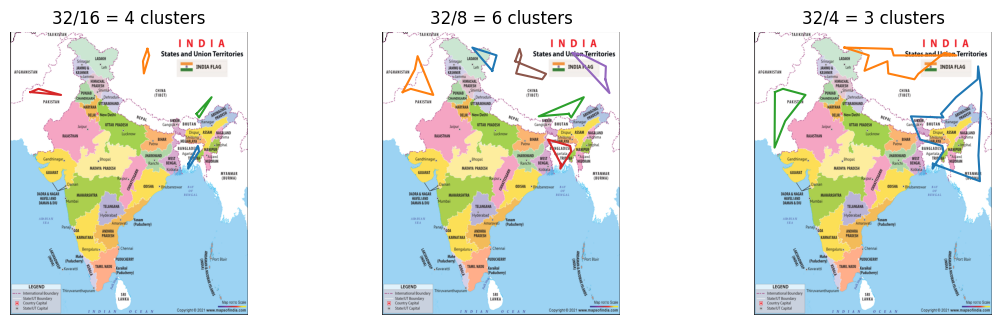

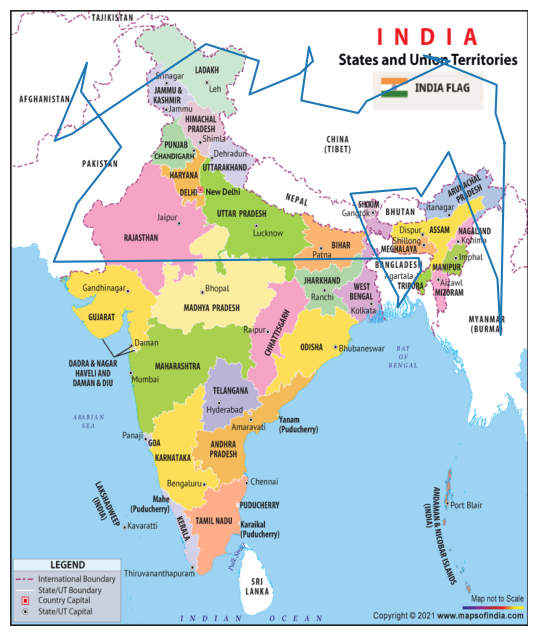

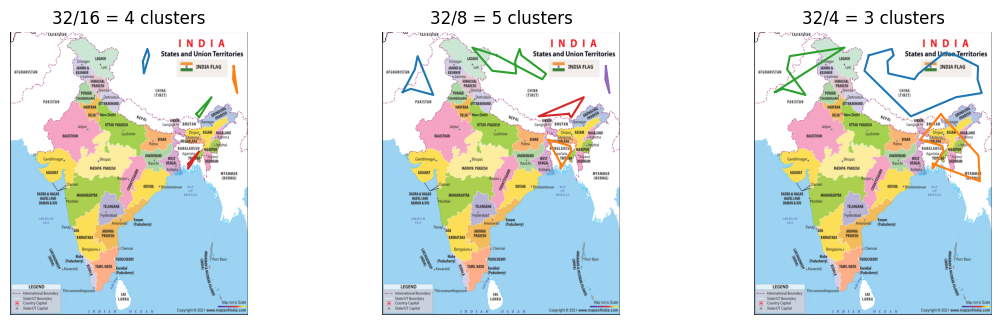

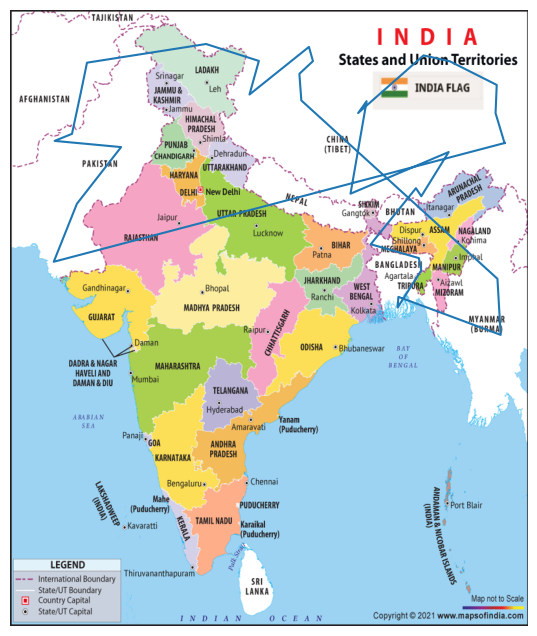

In [15]:
N = 32
result = KmeansAntColonyRunner(cities[:N], verbose=True, animate=True, backtracking=True, cluster_factor=2)
result = KmeansAntColonyRunner(cities[:N], verbose=True, animate=True, backtracking=True, cluster_factor=2)


N=32  | 10362 -> 3018 |    2s | ants:   129 | trips:  2 | 
solve(3) 95 -> 95 {'ant_count': 12, 'ants_used': 18, 'round_trips': 2, 'time': 0.0}
solve(3) 95 -> 95 {'ant_count': 12, 'ants_used': 18, 'round_trips': 2, 'time': 0.0}
solve(3) 224 -> 224 {'ant_count': 12, 'ants_used': 14, 'round_trips': 2, 'time': 0.0}
solve(3) 242 -> 242 {'ant_count': 12, 'ants_used': 21, 'round_trips': 2, 'time': 0.0}
solve(3) 95 -> 95 {'ant_count': 12, 'ants_used': 15, 'round_trips': 2, 'time': 0.0}
solve(3) 242 -> 242 {'ant_count': 12, 'ants_used': 20, 'round_trips': 2, 'time': 0.0}
solve(3) 170 -> 170 {'ant_count': 12, 'ants_used': 20, 'round_trips': 2, 'time': 0.0}
solve(3) 182 -> 182 {'ant_count': 12, 'ants_used': 16, 'round_trips': 2, 'time': 0.0}
solve(3) 211 -> 211 {'ant_count': 12, 'ants_used': 18, 'round_trips': 2, 'time': 0.0}
solve(4) 173 -> 172 {'ant_count': 16, 'ants_used': 18, 'round_trips': 2, 'time': 0.0}
solve(3) 95 -> 95 {'ant_count': 12, 'ants_used': 15, 'round_trips': 2, 'time': 0.0}
sol

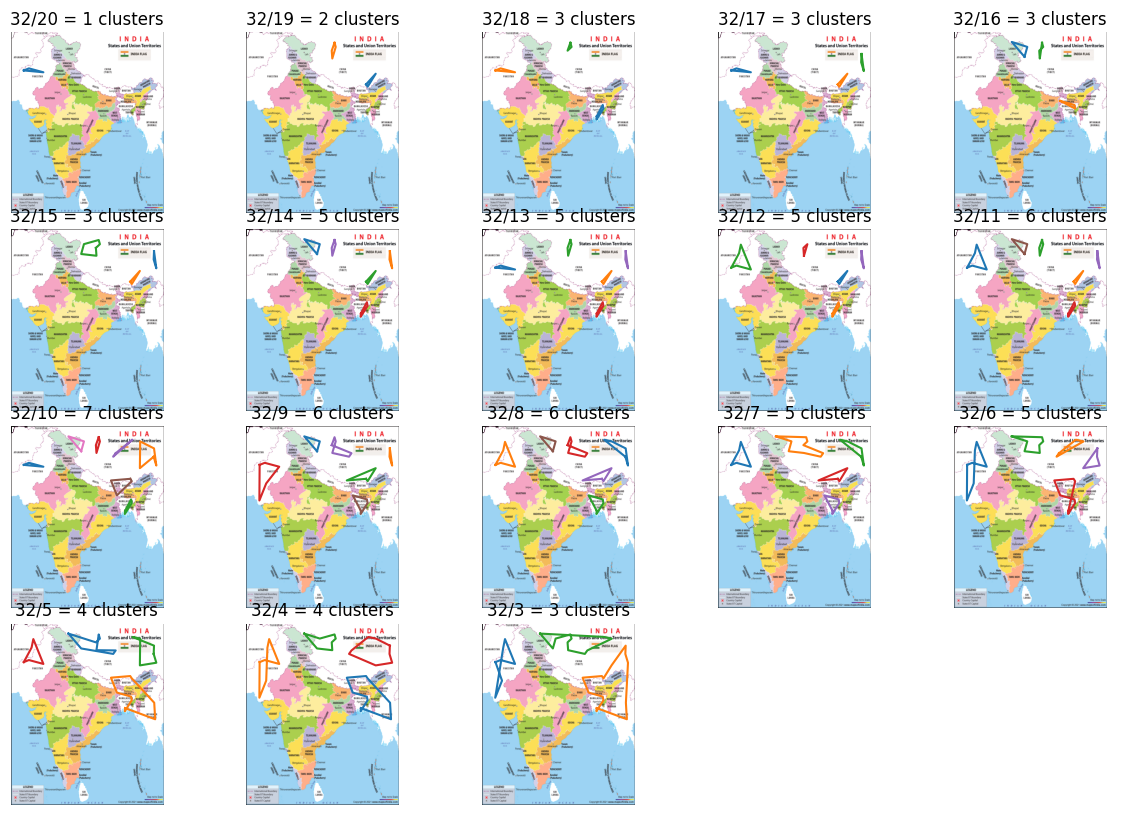

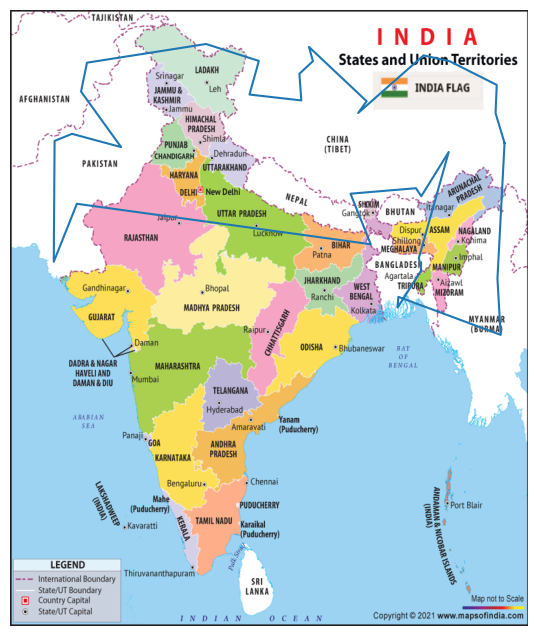

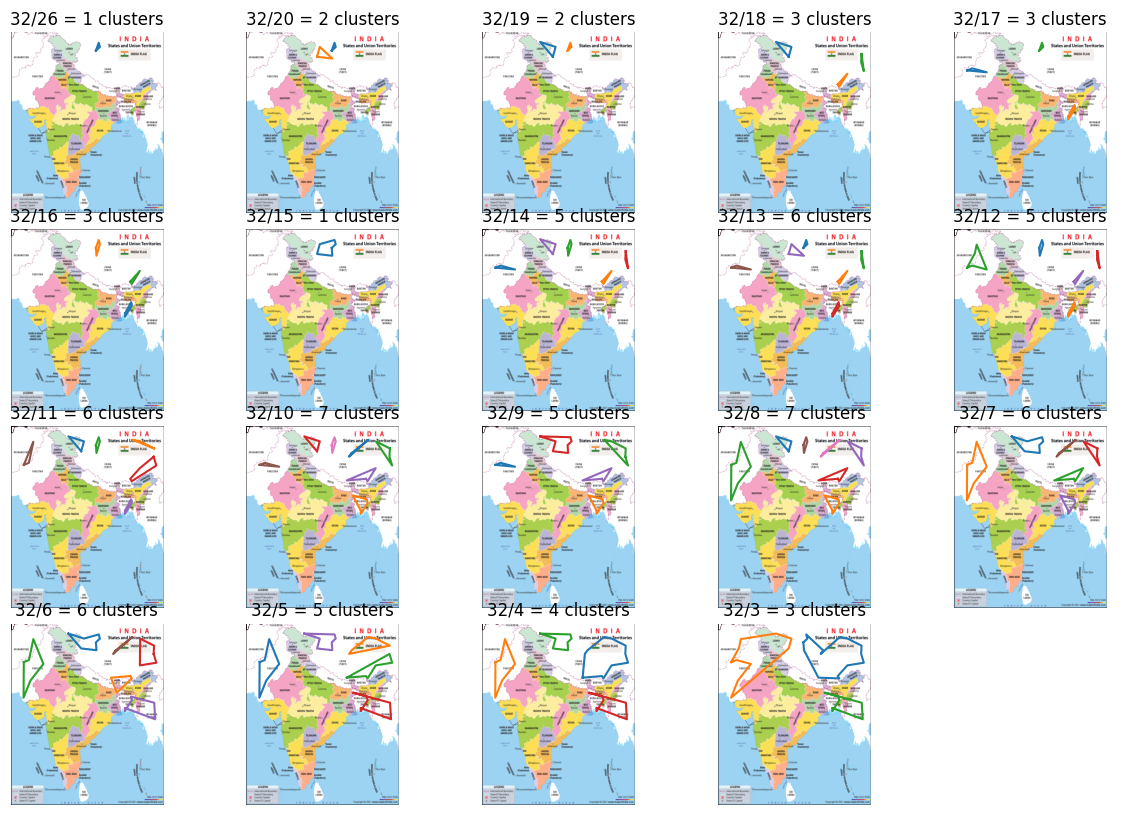

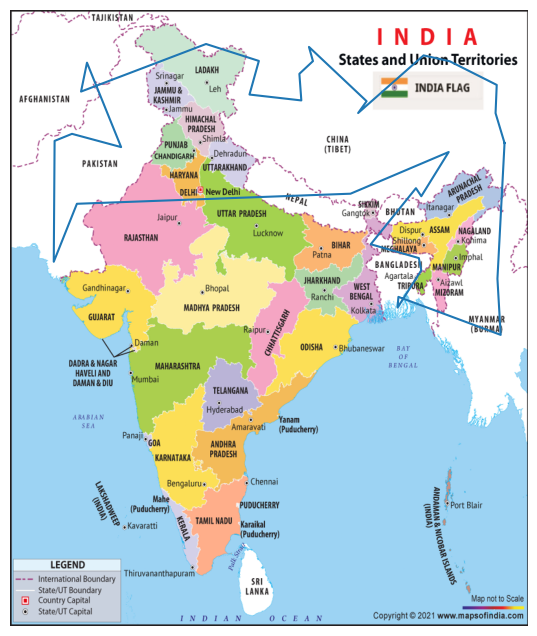

In [16]:
N = 32
result = KmeansAntColonyRunner(cities[:N], verbose=False, animate=True)
result = KmeansAntColonyRunner(cities[:N], verbose=True,  animate=True, backtracking=True)

N=32  | 10362 -> 3147 |    3s | ants:   382 | trips:  3 | 
N=32  | 10362 -> 3103 |    2s | ants:   129 | trips:  2 | backtracking=True


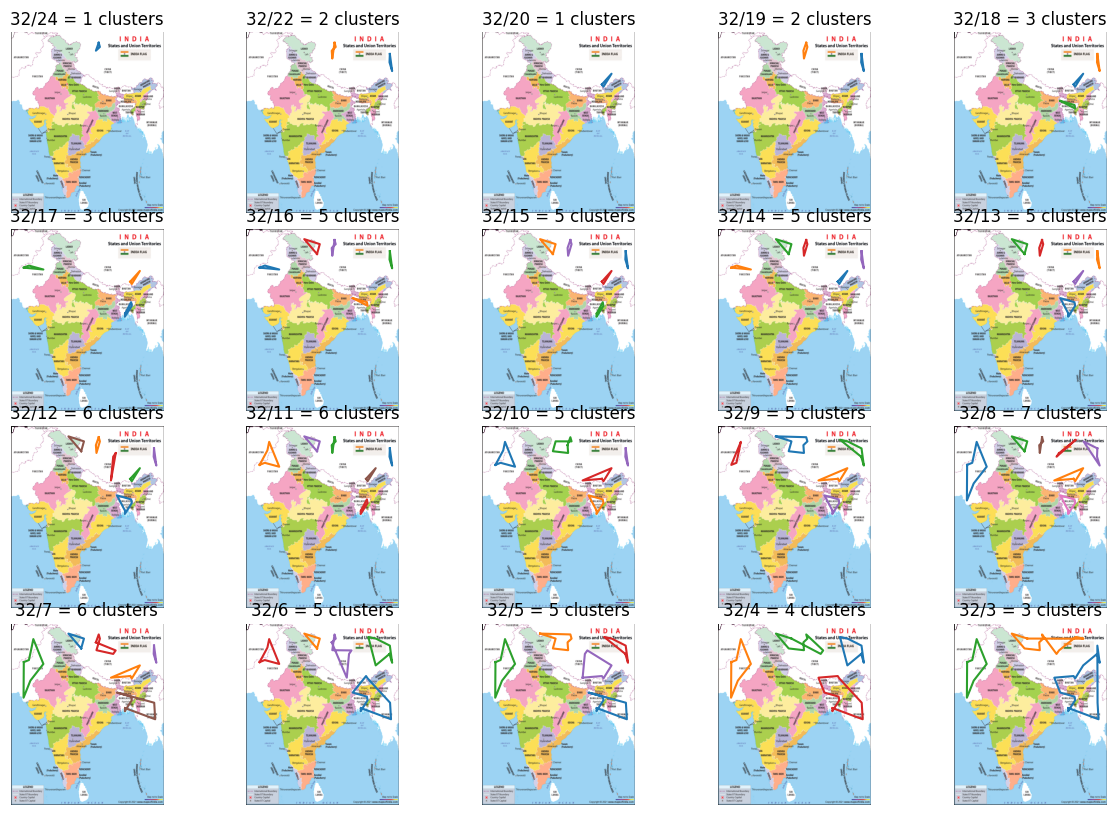

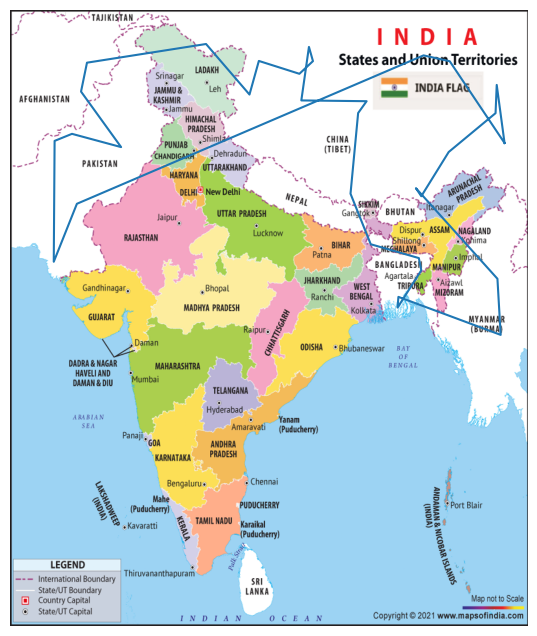

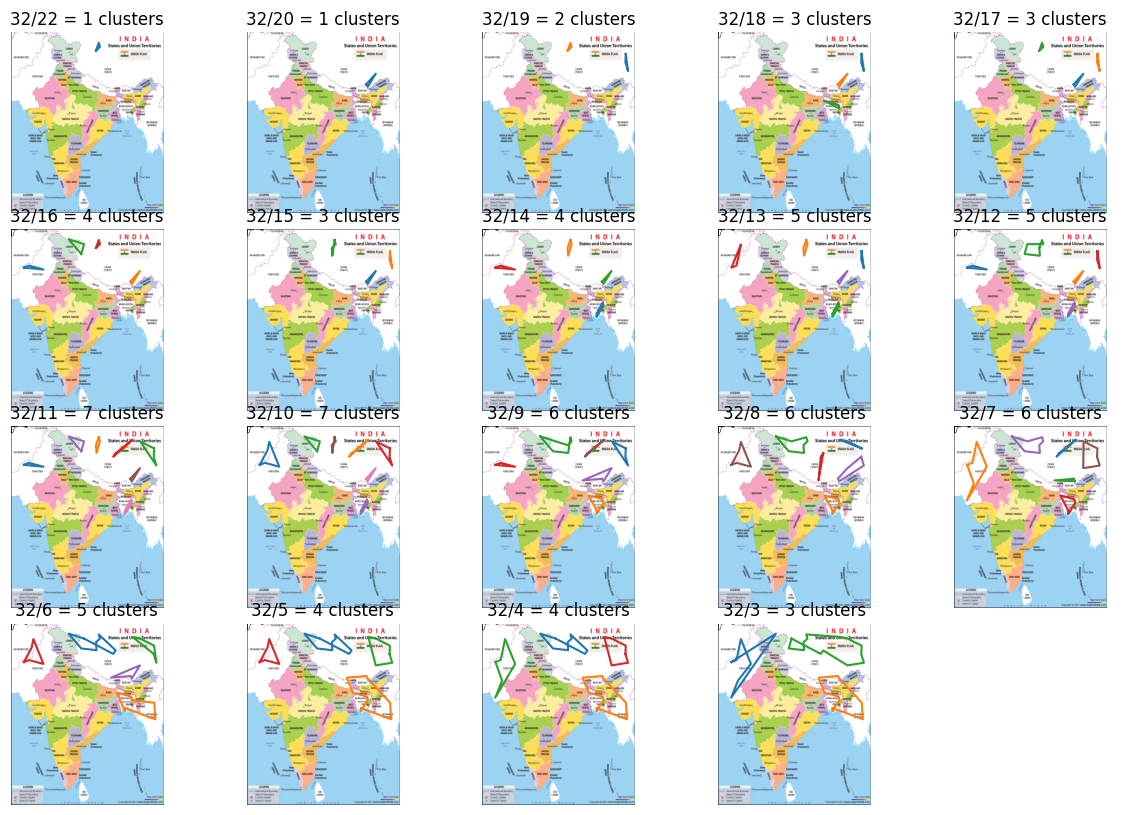

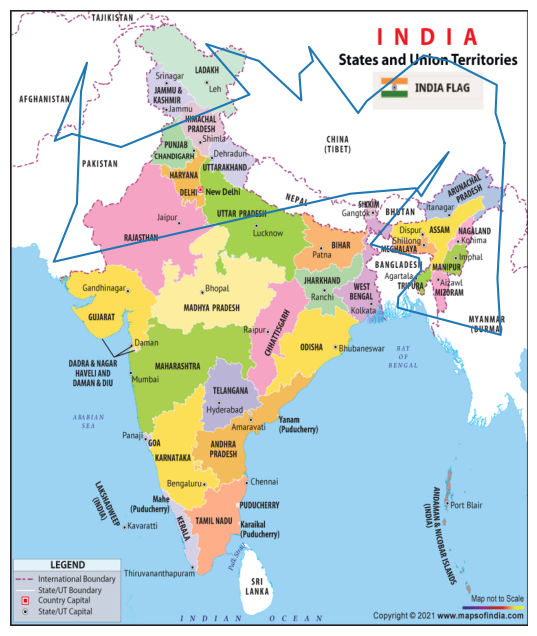

In [17]:
N = 32
result = KmeansAntColonyRunner(cities[:N], verbose=False, animate=True)
result = KmeansAntColonyRunner(cities[:N], verbose=False, animate=True, backtracking=True)

N=64  | 23192 -> 3761 |    7s | ants:   257 | trips:  2 | 
N=64  | 23192 -> 3917 |    9s | ants:   257 | trips:  2 | backtracking=True


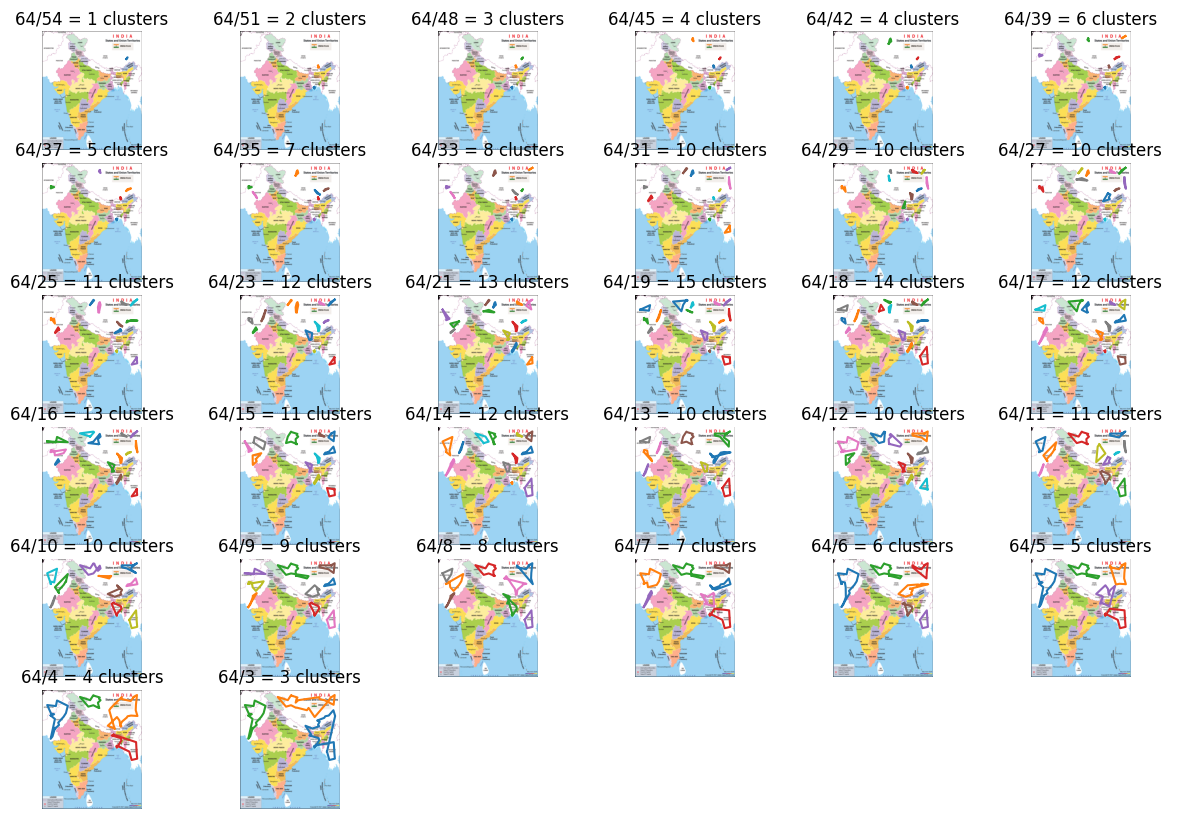

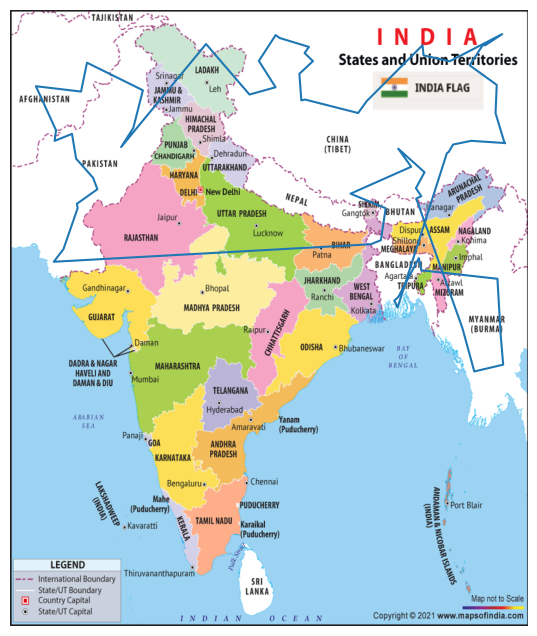

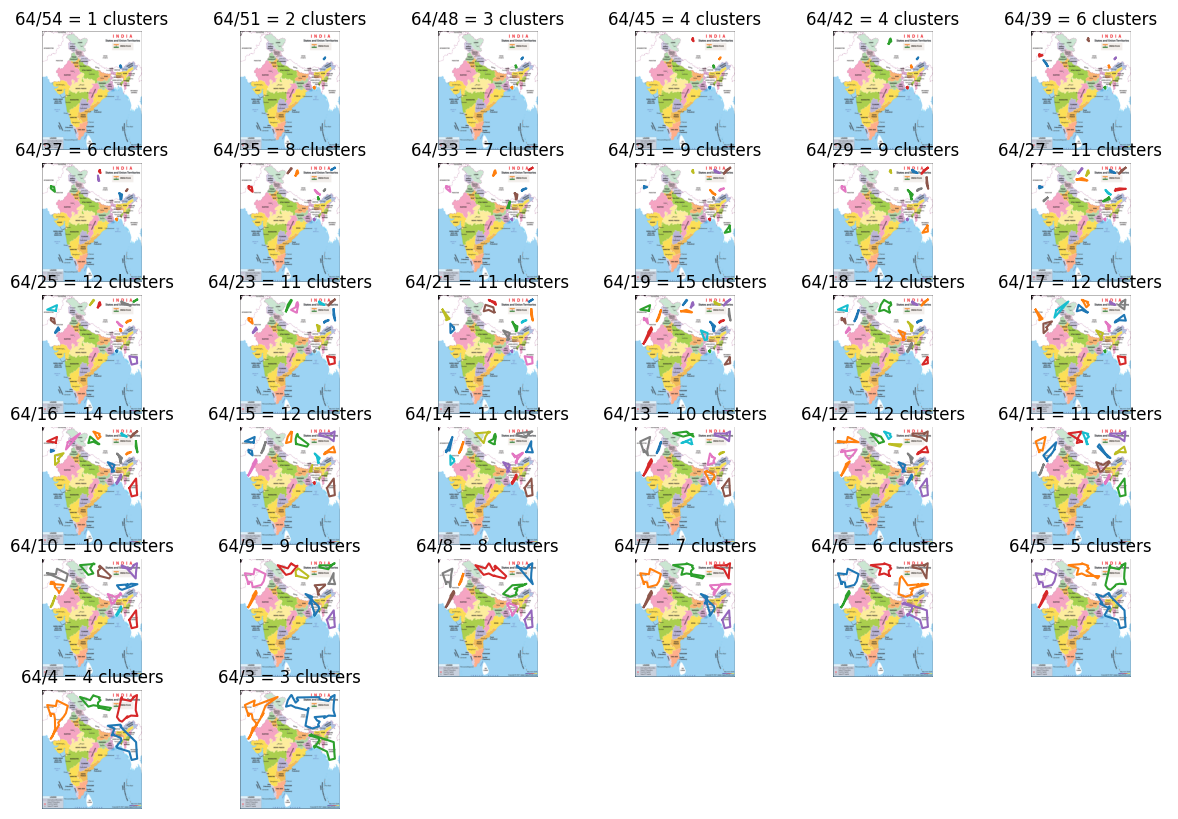

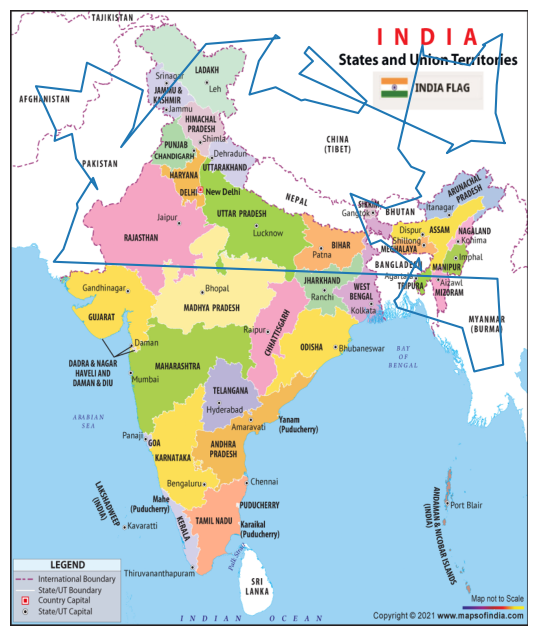

In [18]:
N = 64
result = KmeansAntColonyRunner(cities[:N], verbose=False, animate=True)
result = KmeansAntColonyRunner(cities[:N], verbose=False, animate=True, backtracking=True)

N=128 | 44692 -> 5076 |   24s | ants:   513 | trips:  2 | 
N=128 | 44692 -> 5190 |   27s | ants:   513 | trips:  2 | backtracking=True


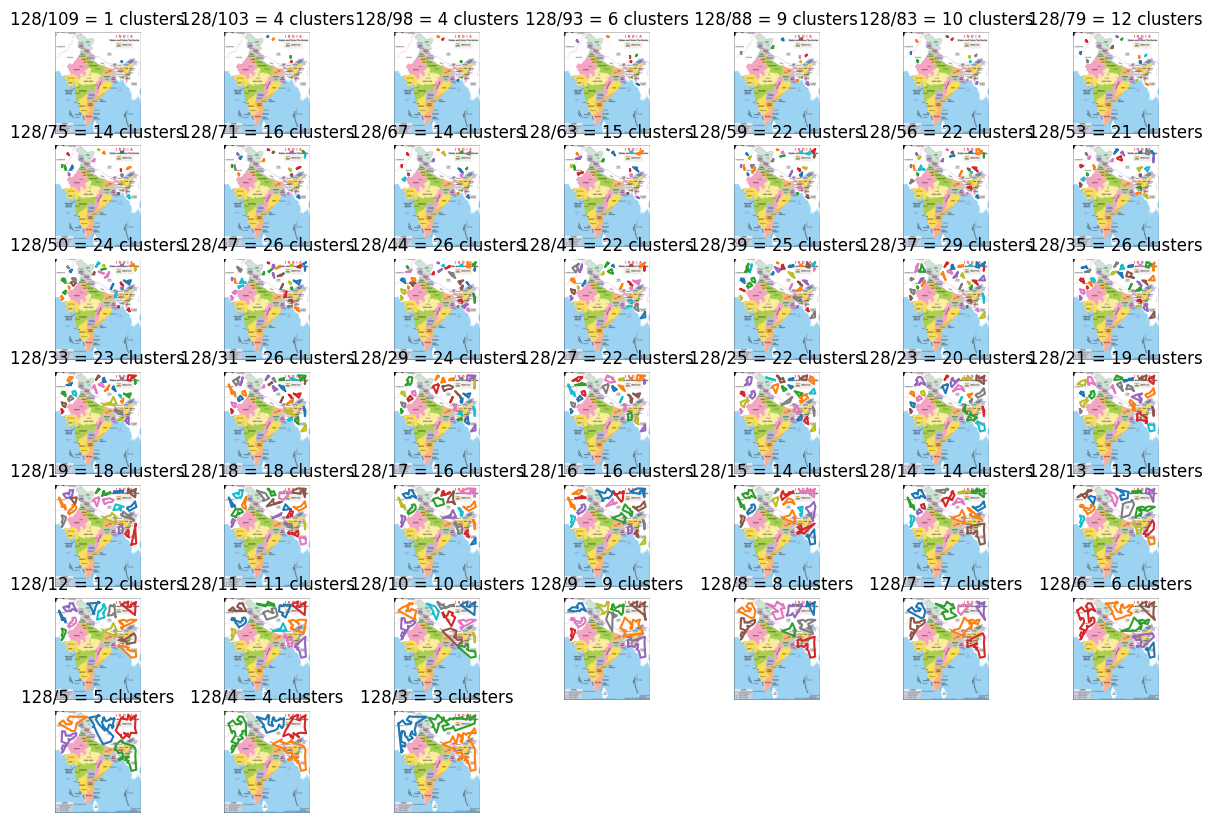

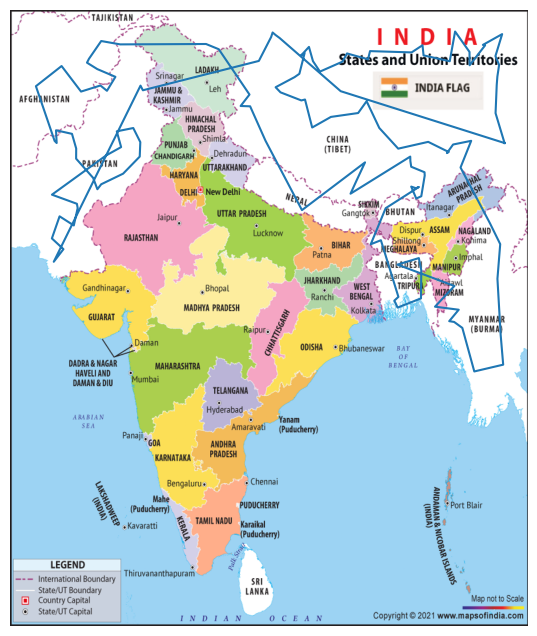

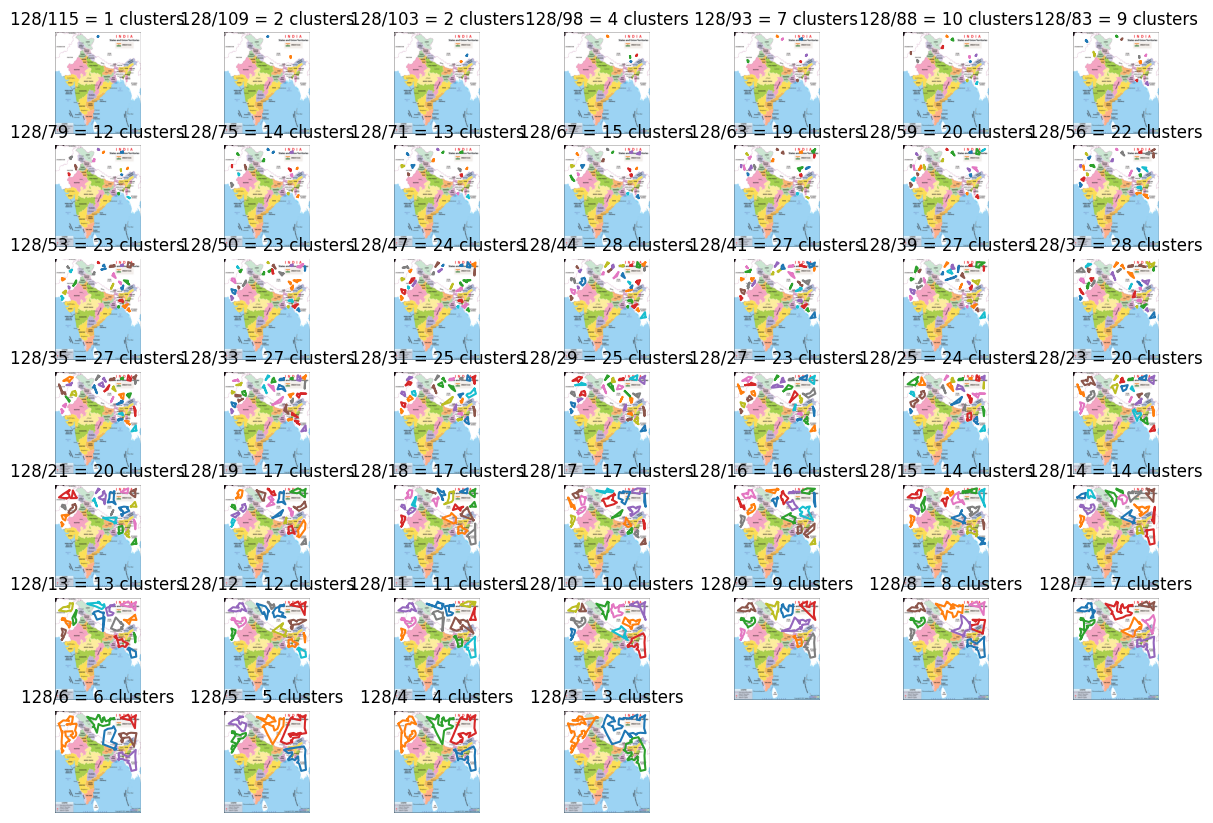

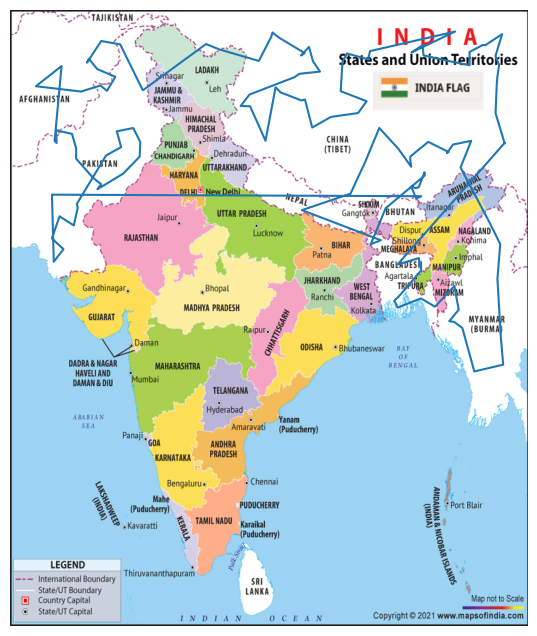

In [19]:
N = 128
result = KmeansAntColonyRunner(cities[:N], verbose=False, animate=True)
result = KmeansAntColonyRunner(cities[:N], verbose=False, animate=True, backtracking=True)